In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import log_softmax
from torch.utils.data import random_split
from torchvision.models import resnet18


import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from jiwer import wer, cer

### Train

In [2]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduce H y W
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # fuerza H = 1, W se mantiene
        )

        # Supongamos que la salida del CNN tiene tamaño (B, 128, 1, W)
        # y por tanto la entrada al RNN será (W, B, 128)
        self.rnn = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        conv = self.cnn(x)               # (B, 128, H=1, W)
        conv = conv.squeeze(2)           # (B, 128, W)
        conv = conv.permute(2, 0, 1)     # (W, B, 128)
        rnn_out, _ = self.rnn(conv)      # (W, B, 512)
        out = self.fc(rnn_out)           # (W, B, num_classes)
        return out


In [3]:
train = True

In [4]:
# Config
CHARACTERS = "-abcdefghijklmnopqrstuvwxyz0123456789"
char_to_idx = {c: i for i, c in enumerate(CHARACTERS)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

class OCRDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        df = pd.read_csv(csv_file, header=None)
        self.samples = df.values.tolist()
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        label = str(label)
        img = Image.open(f"{self.img_dir}/{img_path.split('/')[-1]}").convert('L')
        img = self.transform(img)
        label_idx = [char_to_idx[c] for c in label if c in char_to_idx]
        return img, torch.tensor(label_idx, dtype=torch.long), len(label_idx)


def collate_fn(batch):
    imgs, labels, label_lengths = zip(*batch)
    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    return imgs, labels, torch.tensor(label_lengths)

# Load the full dataset
full_dataset = OCRDataset("ocr_dataset_train/labels.csv", "ocr_dataset_train/img")

# Define the sizes for training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [5]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CRNN(num_classes=len(CHARACTERS)).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [6]:
# Early stopping params
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_path = "ocr_model_gamma.pth"

if train:
    for epoch in range(30):
        model.train()
        train_loss = 0.0

        with tqdm(train_loader, unit="batch") as tepoch:
            for imgs, labels, label_lengths in tepoch:
                imgs = imgs.to(device)
                labels = labels.to(device)

                logits = model(imgs)  # shape: (T, N, C)
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                tepoch.set_description(f"Epoch {epoch+1}")
                tepoch.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels, label_lengths in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                logits = model(imgs)
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

                loss = criterion(log_probs, labels, input_lengths, label_lengths)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # ---- Early Stopping Check ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model to '{best_model_path}'")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: 100%|██████████| 2500/2500 [18:50<00:00,  2.21batch/s, loss=0.658]


Epoch 1 - Train Loss: 1.9705, Val Loss: 0.5882
Saved new best model to 'ocr_model_gamma.pth'


Epoch 2: 100%|██████████| 2500/2500 [02:46<00:00, 14.98batch/s, loss=0.378]


Epoch 2 - Train Loss: 0.4291, Val Loss: 0.3473
Saved new best model to 'ocr_model_gamma.pth'


Epoch 3: 100%|██████████| 2500/2500 [02:45<00:00, 15.08batch/s, loss=0.266]


Epoch 3 - Train Loss: 0.3128, Val Loss: 0.2930
Saved new best model to 'ocr_model_gamma.pth'


Epoch 4: 100%|██████████| 2500/2500 [02:45<00:00, 15.14batch/s, loss=0.274] 


Epoch 4 - Train Loss: 0.2721, Val Loss: 0.2660
Saved new best model to 'ocr_model_gamma.pth'


Epoch 5: 100%|██████████| 2500/2500 [02:45<00:00, 15.13batch/s, loss=0.239] 


Epoch 5 - Train Loss: 0.2496, Val Loss: 0.2465
Saved new best model to 'ocr_model_gamma.pth'


Epoch 6: 100%|██████████| 2500/2500 [02:46<00:00, 14.98batch/s, loss=0.1]   


Epoch 6 - Train Loss: 0.2351, Val Loss: 0.2398
Saved new best model to 'ocr_model_gamma.pth'


Epoch 7: 100%|██████████| 2500/2500 [02:47<00:00, 14.92batch/s, loss=0.263] 


Epoch 7 - Train Loss: 0.2241, Val Loss: 0.2391
Saved new best model to 'ocr_model_gamma.pth'


Epoch 8: 100%|██████████| 2500/2500 [02:45<00:00, 15.09batch/s, loss=0.21]  


Epoch 8 - Train Loss: 0.2152, Val Loss: 0.2259
Saved new best model to 'ocr_model_gamma.pth'


Epoch 9: 100%|██████████| 2500/2500 [02:45<00:00, 15.13batch/s, loss=0.131] 


Epoch 9 - Train Loss: 0.2084, Val Loss: 0.2187
Saved new best model to 'ocr_model_gamma.pth'


Epoch 10: 100%|██████████| 2500/2500 [02:45<00:00, 15.14batch/s, loss=0.236] 


Epoch 10 - Train Loss: 0.2025, Val Loss: 0.2184
Saved new best model to 'ocr_model_gamma.pth'


Epoch 11: 100%|██████████| 2500/2500 [02:45<00:00, 15.07batch/s, loss=0.232] 


Epoch 11 - Train Loss: 0.1966, Val Loss: 0.2197
No improvement for 1 epoch(s)


Epoch 12: 100%|██████████| 2500/2500 [06:51<00:00,  6.08batch/s, loss=0.218]  


Epoch 12 - Train Loss: 0.1914, Val Loss: 0.2179
Saved new best model to 'ocr_model_gamma.pth'


Epoch 13: 100%|██████████| 2500/2500 [07:48<00:00,  5.34batch/s, loss=0.219]  


Epoch 13 - Train Loss: 0.1850, Val Loss: 0.2171
Saved new best model to 'ocr_model_gamma.pth'


Epoch 14: 100%|██████████| 2500/2500 [02:56<00:00, 14.20batch/s, loss=0.0833]


Epoch 14 - Train Loss: 0.1791, Val Loss: 0.2221
No improvement for 1 epoch(s)


Epoch 15: 100%|██████████| 2500/2500 [02:55<00:00, 14.25batch/s, loss=0.177] 


Epoch 15 - Train Loss: 0.1727, Val Loss: 0.2193
No improvement for 2 epoch(s)


Epoch 16: 100%|██████████| 2500/2500 [02:50<00:00, 14.69batch/s, loss=0.135] 


Epoch 16 - Train Loss: 0.1659, Val Loss: 0.2246
No improvement for 3 epoch(s)


Epoch 17: 100%|██████████| 2500/2500 [02:46<00:00, 15.01batch/s, loss=0.151] 


Epoch 17 - Train Loss: 0.1587, Val Loss: 0.2258
No improvement for 4 epoch(s)


Epoch 18: 100%|██████████| 2500/2500 [02:47<00:00, 14.90batch/s, loss=0.226] 


Epoch 18 - Train Loss: 0.1508, Val Loss: 0.2356
No improvement for 5 epoch(s)
Early stopping triggered.


### Simple Test

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_classes=len(CHARACTERS)).to(device)
model.load_state_dict(torch.load("ocr_model_gamma.pth", map_location=device))
model.eval()

C:\Users\ignac\AppData\Local\Temp\ipykernel_1516\2256506409.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ocr_model_gamma.pth", map_l

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(1, None))
  )
  (rnn): LSTM(128, 256, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=37, bias=True)
)

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_image(image_path):
    image = Image.open(image_path).convert("L")
    return transform(image).unsqueeze(0).to(device) 

In [9]:
def decode_prediction(logits, idx_to_char):
    # Logits are of shape (T, B, C) where T is sequence length, B is batch size, and C is number of classes
    pred = logits.argmax(dim=2)  # (T, B)
    pred = pred.permute(1, 0)    # (B, T) to (B, T)

    # Convert indices to characters using idx_to_char mapping
    decoded_texts = []
    for i in range(pred.size(0)):  # Iterate over batch size
        decoded_text = ''.join([idx_to_char[idx.item()] for idx in pred[i] if idx.item() != 0])  # Assuming 0 is the padding token
        decoded_texts.append(decoded_text)
    return decoded_texts


Texto detectado: ['ital']


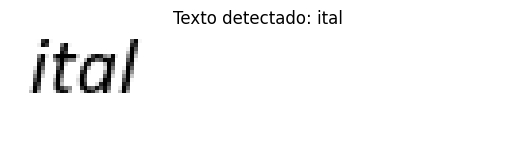

In [12]:
image_tensor = load_image("D:/my_files/universidad/intro_imagenes/EL7007/src/ocr_dataset_train/img/00002.png")

with torch.no_grad():
    logits = model(image_tensor)  # (T, B, C)
    logits = logits.log_softmax(2)

predicted_texts = decode_prediction(logits, idx_to_char)
print("Texto detectado:", predicted_texts)

img_np = image_tensor.squeeze().cpu().numpy()  # -> (H, W)
# plt.imshow(img_np, cmap='gray')

plt.imshow(img_np, cmap='gray')
plt.title(f"Texto detectado: {predicted_texts[0]}")
plt.axis('off')
plt.show()

In [13]:
def load_and_binarize_image(path, threshold=100):
    # Cargar imagen y convertir a escala de grises
    image = Image.open(path).convert("L")  # Modo "L" es escala de grises

    # Convertir a numpy array
    image_np = np.array(image)

    # Invertir si el fondo es negro y texto blanco (opcional)
    image_np = 255 - image_np

    # Aplicar umbral: letras negras (0), fondo blanco (255)
    binarized = (image_np < threshold).astype(np.uint8) * 255

    # Convertir de nuevo a tensor
    image_tensor = transforms.ToTensor()(Image.fromarray(binarized))  # (1, H, W)
    return image_tensor.unsqueeze(0)  # Añadir batch -> (1, 1, H, W)

Texto detectado: ['corrtte']


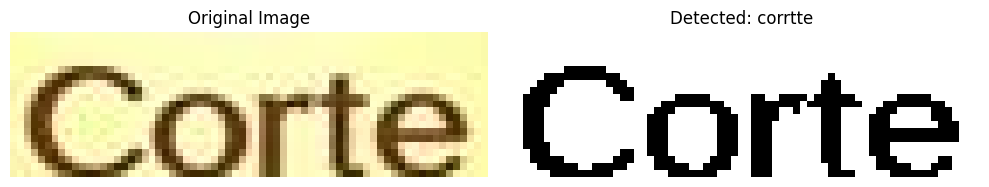

In [25]:
image_path = "D:/my_files/universidad/intro_imagenes/EL7007/src/ocr_dataset_test/corte.png"
image_tensor = load_and_binarize_image(image_path).cuda()

# Inference
with torch.no_grad():
    logits = model(image_tensor)
    logits = logits.log_softmax(2)

predicted_texts = decode_prediction(logits, idx_to_char)
print("Texto detectado:", predicted_texts)

# Load original image
image = Image.open(image_path)

# Convert image_tensor to CPU and NumPy array for display
# Assumes image_tensor shape is (1, C, H, W)
tensor_image = image_tensor.squeeze().detach().cpu()  # shape: (C, H, W) or (H, W)
if tensor_image.ndim == 3:
    tensor_image = tensor_image.permute(1, 2, 0)  # (H, W, C)

# Plot original and tensor image
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Tensor image
plt.subplot(1, 2, 2)
plt.imshow(tensor_image, cmap='gray' if tensor_image.ndim == 2 or tensor_image.shape[2] == 1 else None)
plt.title(f"Detected: {predicted_texts[0]}")
plt.axis('off')

plt.tight_layout()
plt.show()

### Test

In [15]:
# val_dataset = OCRDataset("ocr_dataset_test/labels.csv", "ocr_dataset_/img")
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [16]:
def calculate_accuracy(model, dataloader, device, idx_to_char):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader):
            imgs = imgs.to(device)
            logits = model(imgs)  # [T, B, C]
            log_probs = log_softmax(logits, dim=2)

            # Predicción y decodificación
            pred_texts = decode_prediction(log_probs, idx_to_char)

            # Reconstrucción de etiquetas reales
            labels = labels.cpu().tolist()
            lengths = label_lengths.cpu().tolist()

            gt_texts = []
            i = 0
            for l in lengths:
                gt_texts.append("".join([idx_to_char.get(c, "") for c in labels[i:i+l]]))
                i += l

            for pred, gt in zip(pred_texts, gt_texts):
                if pred == gt:
                    correct += 1
                total += 1

    return correct / total if total > 0 else 0.0

In [17]:
# val_accuracy = calculate_accuracy(model, val_loader, device, idx_to_char)
# print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

### WER

In [18]:
def calculate_wer(model, dataloader, device, idx_to_char):
    model.eval()
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader, desc="Calculating WER"):
            imgs = imgs.to(device)
            logits = model(imgs)
            logits = logits.log_softmax(2)

            pred_texts = decode_prediction(logits, idx_to_char)

            label_offset = 0
            for length in label_lengths:
                true_text = ''.join([idx_to_char[idx.item()] for idx in labels[label_offset:label_offset + length]])
                ground_truths.append(true_text)
                label_offset += length

            predictions.extend(pred_texts)

    return wer(ground_truths, predictions)


In [19]:
val_wer = calculate_wer(model, val_loader, device, idx_to_char)
print(f"Validation WER (Word Error Rate): {val_wer * 100:.2f}%")

Calculating WER: 100%|██████████| 625/625 [01:33<00:00,  6.69it/s]


Validation WER (Word Error Rate): 84.09%


### CER

In [20]:
def calculate_cer(model, dataloader, device, idx_to_char):
    model.eval()
    ground_truths = []
    predictions = []

    with torch.no_grad():
        for imgs, labels, label_lengths in tqdm(dataloader, desc="Evaluando CER"):
            imgs = imgs.to(device)
            logits = model(imgs)
            logits = logits.log_softmax(2)

            pred_texts = decode_prediction(logits, idx_to_char)

            label_offset = 0
            for length in label_lengths:
                true_text = ''.join([idx_to_char[idx.item()] for idx in labels[label_offset:label_offset + length]])
                ground_truths.append(true_text)
                label_offset += length

            predictions.extend(pred_texts)

    return cer(ground_truths, predictions)


In [21]:
val_cer = calculate_cer(model, val_loader, device, idx_to_char)
print(f"Validation CER (Character Error Rate): {val_cer * 100:.2f}%")

Evaluando CER: 100%|██████████| 625/625 [01:38<00:00,  6.32it/s]


Validation CER (Character Error Rate): 33.55%
